# Project IMA201-SkinLesions-AlvarezVahos

*Télécom Paris - IMA201*

*Noviembre 2022*



In [4]:
import ProjectLIB as PL
import importlib
import matplotlib.pyplot as plt
from skimage import data, filters
from skimage import io as skio
from scipy import ndimage, misc
import cv2
import os.path

import numpy as np
#morpho
import skimage.morphology as morpho  
import skimage.feature as skf
from scipy import ndimage as ndi
import matplotlib.image

from PIL import Image
from skimage.filters import threshold_otsu

In [5]:
importlib.reload(PL)

<module 'ProjectLIB' from 'C:\\Users\\Usuario\\OneDrive\\Documents\\Telecom\\IMA\\Project\\ima201-skinlesions-alvarezvahos\\ProjectLIB.py'>

### Carga de imágenes.

In [3]:
folder = "melanoma"
imgname = "ISIC_0000146.jpg"
path = os.path.join("dataset", folder, imgname)
image1 = Image.open(path)

#Convert it into the grayscale image
img = PL.RGBtoGRAYnumpy(image1)



## 1 Preprocessing

In this section we take care of conditioning the image well in order to be able to correctly segment the wound. The main obstacle is the hairs in the images, for this we will make a BlackHat that will allow us to correctly segment the hairs of the wound and the rest of the image. 

Thanks to this BlackHat we will obtain a mask where we will have identified the hairs. This mask will then be used to eliminate the hairs identified as foreground in the binarisation of the original image.

#### Contrast sctretching

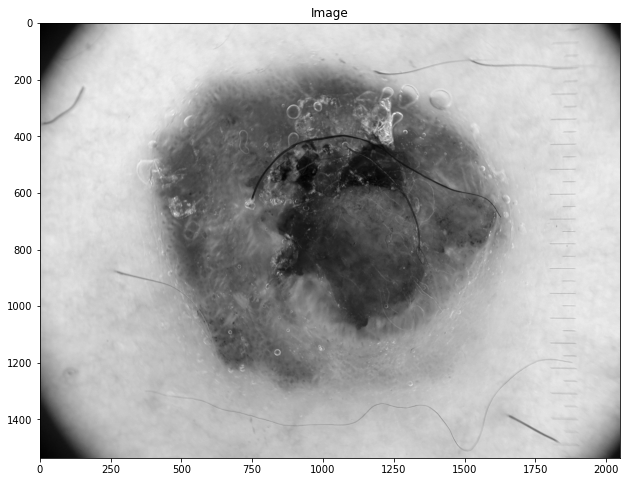

In [4]:
img = PL.contrast_stretching(img)

#img = PL.histogram_equalization(img)

img = ndi.median_filter(img, 2)



plt.figure(figsize=(15,8))
plt.imshow(img, cmap='gray')
plt.title('Image')
plt.show()


### 1.1 BlackHat for Hair removal.

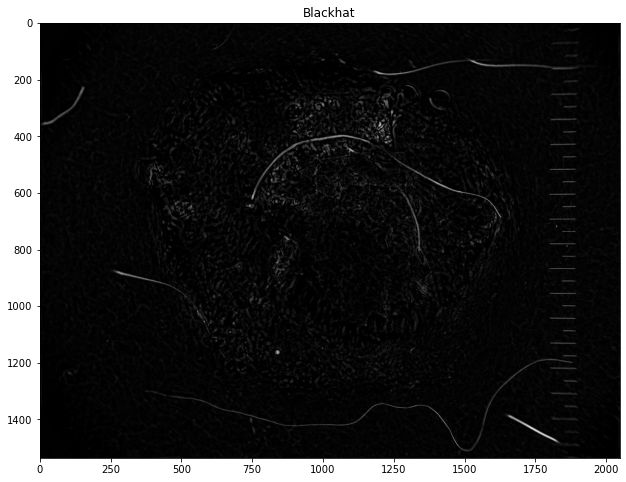

In [5]:
# Kernel for the morphological filtering
kernel = cv2.getStructuringElement(1,(17,17)) #structuring element cross

# Perform the blackHat filtering on the grayscale image to find the hair countours
blackhat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernel)

plt.figure(figsize=(15,8))
plt.imshow(blackhat, cmap='gray')
plt.title('Blackhat')
plt.show()

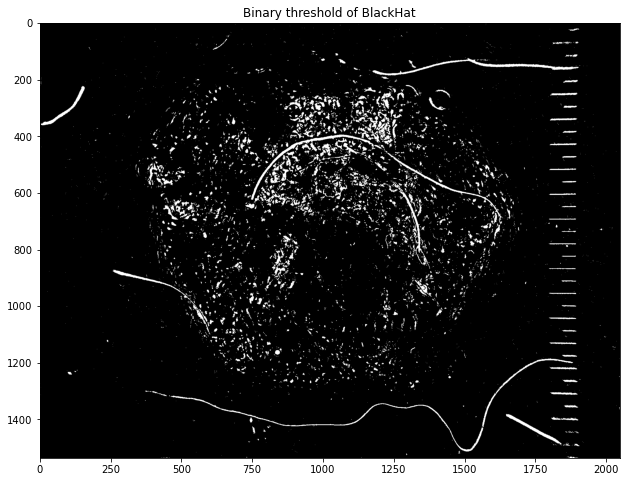

In [6]:
#Segmentation blackhat image

a, thrBH = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY) #binary threshold with threshold=10

plt.figure(figsize=(15,8))
plt.imshow(thrBH, cmap='gray')
plt.title('Binary threshold of BlackHat')
plt.show()

## 2 Processing 

In this part we perform the binarisation with the otsu threshold. Then we add the inverse mask of the hairs (blackhat) and remove them from the foreground.

### 2.1 Otsu of the original image.

In [7]:

thresh = PL.otsu_thresh(img)
binary = img > thresh
print(thresh)

145


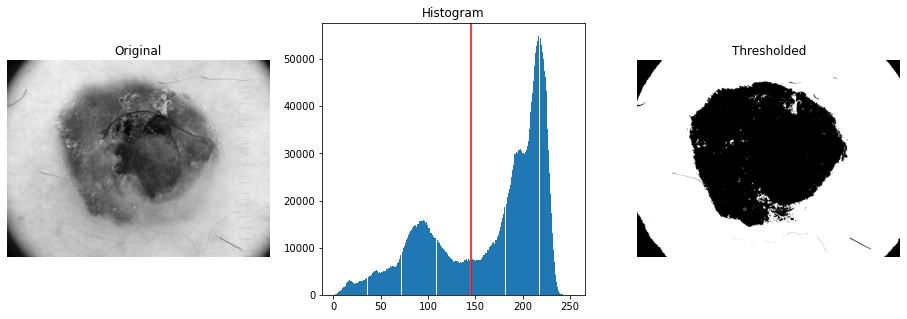

In [8]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

bins=np.max(img)-np.min(img)+1

ax[1].hist(img.ravel(), bins=bins)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

# Hair removal by truncating the mask.

In [9]:
img1 = binary*255 + thrBH #We remove the hair and imperfections from the foreground.


In [10]:
thresh = threshold_otsu(img1)       #OTSU threshhold of the mask with hair remo
print(thresh)
binary = img1 > thresh

0


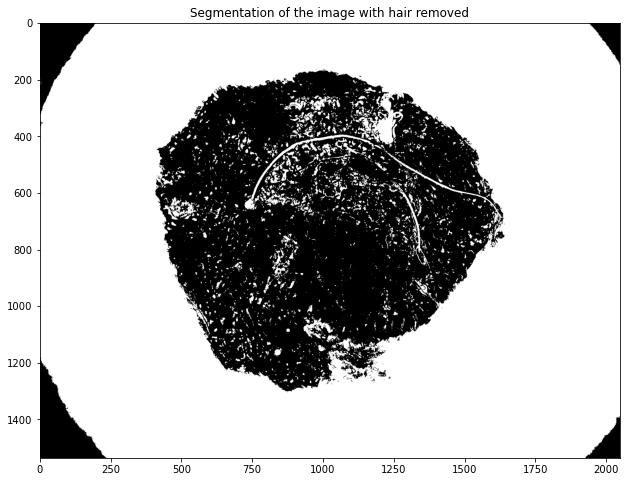

In [11]:
plt.figure(figsize=(15,8))
plt.imshow(binary, cmap='gray')
plt.title('Segmentation of the image with hair removed')
plt.show()

## 3 Postprocessing

The image shall be processed in 4 stages. First we will perform an opening to correct the incorrectly removed pores inside the wound by the hair removal method.
Then the frames introduced by the microscopes and all elements outside the wound that are in contact with the edge of the image will be removed.
Finally we will perform a closing and then an opening in order to correctly segment the entire wound.

## Opening

In [12]:
footprint_disk= morpho.disk(10) #structuring element disk of radius 10

In [13]:
image_op_disk= morpho.binary_opening(binary, footprint_disk) #opening 

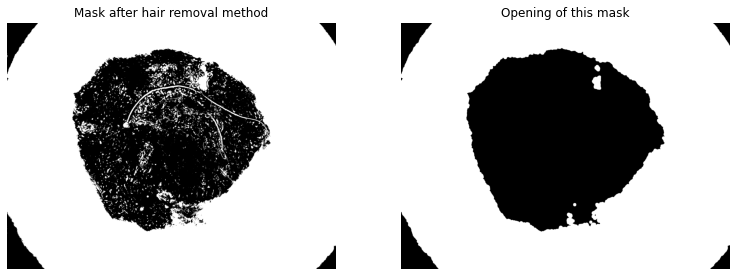

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(20,10))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)

ax[0].imshow(binary, cmap=plt.cm.gray)
ax[0].set_title('Mask after hair removal method')
ax[0].axis('off')

ax[1].imshow(image_op_disk, cmap=plt.cm.gray)
ax[1].set_title('Opening of this mask')
ax[1].axis('off')

plt.show()

## Suppression des bords

To achieve the elimination of the frames introduced by the microscope, we first introduce a 10-bit wide black frame to join all the elements in contact with the edge. Then we change all these to the background with the help of the function cv2.floodfill and the starting point (0,0).

In [15]:
ima = image_op_disk*255  #truncate to int values
pad = cv2.copyMakeBorder(ima, 1,1,1,1, cv2.BORDER_CONSTANT, value=0) #Introduction of a black frame width 1


In [16]:
h, w = pad.shape

# create zeros mask 2 pixels larger in each dimension
mask = np.zeros([h + 2, w + 2], np.uint8)

img_floodfill = cv2.floodFill(pad, mask, (0,0), 255, (5), (0), flags=8)[1] #Truncate to 255 all the elements connected to (0,0)

img_floodfill = img_floodfill[1:(h-1), 1:(w-1)] #reshape to original size (border added pixels)

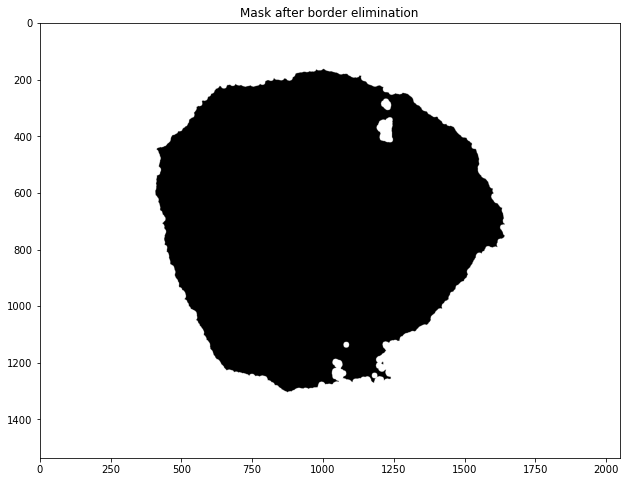

In [17]:
plt.figure(figsize=(15,8))
plt.imshow(img_floodfill, cmap='gray')
plt.title('Mask after border elimination')
plt.show()

In [18]:
if ((np.count_nonzero(img_floodfill)/(h*w))>0.9):  
    print("Without histogram equalizator")
    

## Closing

In [19]:
footprint_disk= morpho.disk(50) #structuring element disk of radius 30


In [20]:
image_closing_disk= morpho.binary_closing(img_floodfill, footprint_disk) #closing 


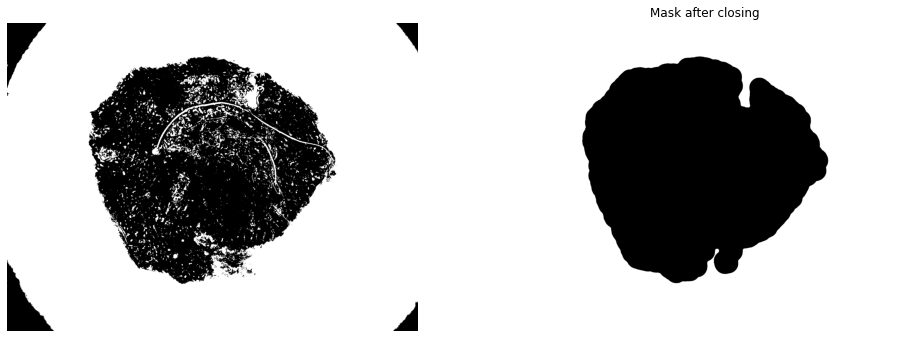

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(25, 15))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)

ax[0].imshow(binary, cmap=plt.cm.gray)
ax[0].set_title('')
ax[0].axis('off')

ax[1].imshow(image_closing_disk, cmap=plt.cm.gray)
ax[1].set_title('Mask after closing')
ax[1].axis('off')

plt.show()

### Opening

In [22]:
footprint_disk= morpho.disk(50)
fin = morpho.binary_opening(image_closing_disk, footprint_disk)

#### Final result

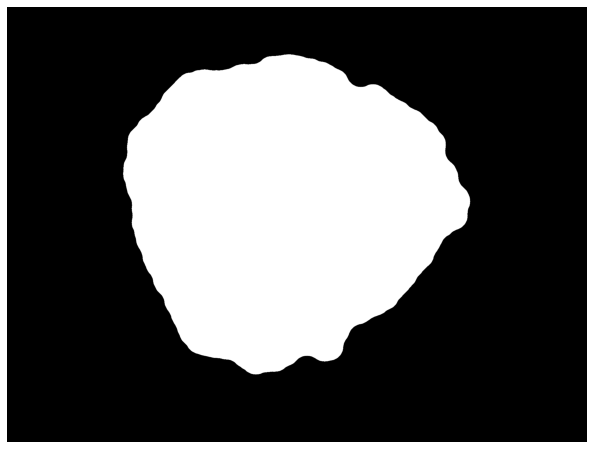

In [23]:
plt.figure(figsize=(15,8))
plt.imshow(fin*(-1), cmap='gray')
plt.axis('off')
plt.show()

# Automatic method

In the previous section we displayed an example of the method. Here we implement the method automatically as a function.

In [2]:
mel_nums = ['030', '046', '049', '140', '142', '143', '145', '146', '150', '151']
imgname = 'ISIC_0000'

In [ ]:
for i in mel_nums:
    print(i)
    path = os.path.join('dataset', 'melanoma', imgname+i+'.jpg' )
    path_save = os.path.join("dataset", 'melanoma', "SEG_"+imgname+i+'.jpg')
    image = Image.open(path)
    
    ima = PL.RGBtoGRAYnumpy(image) #Convert it into the grayscale image
    out = PL.seg_method(ima)
    
    im = Image.fromarray(out)
    im.save(path_save)
    

030
046
049


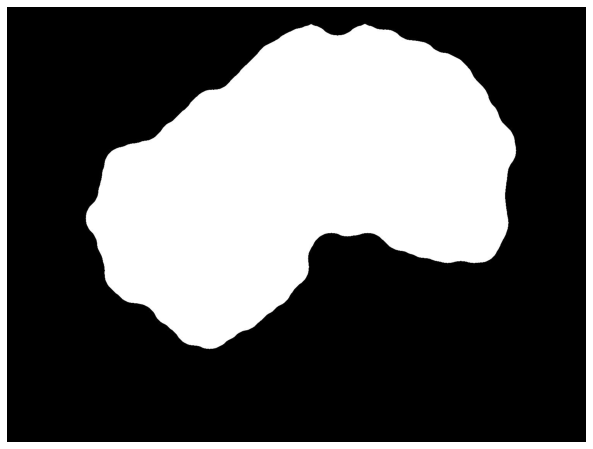

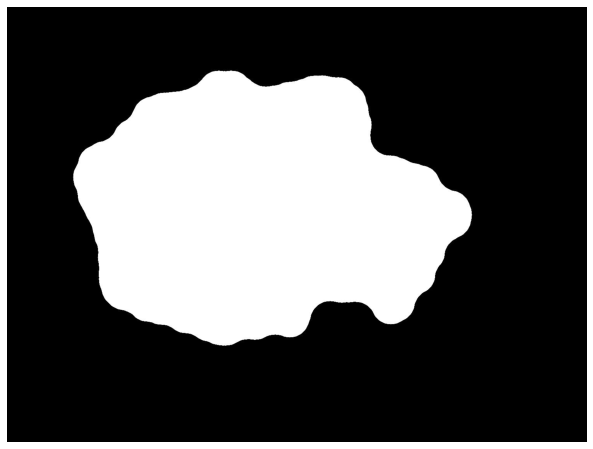

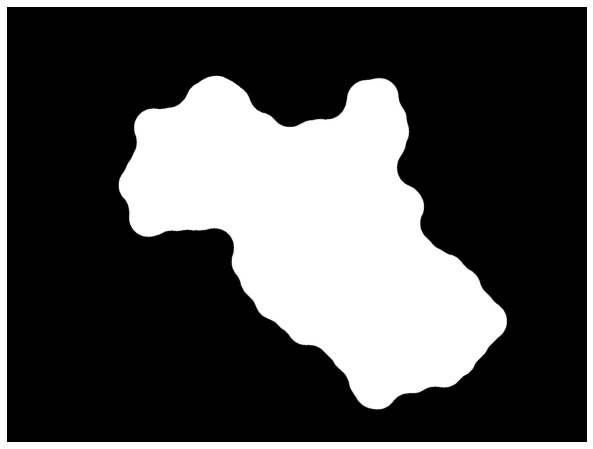

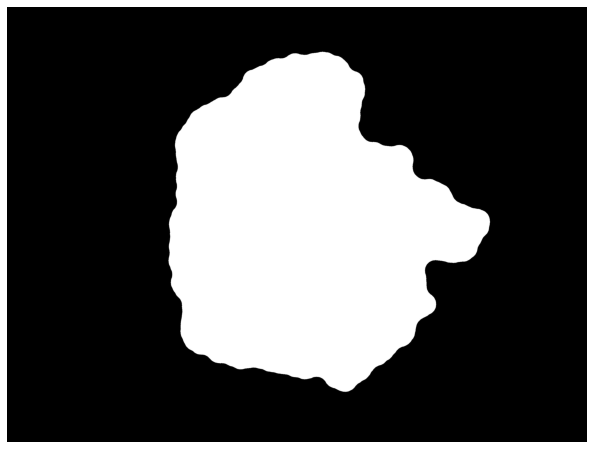

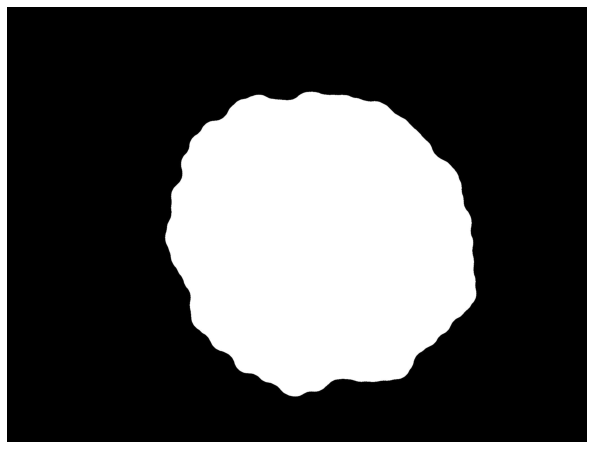

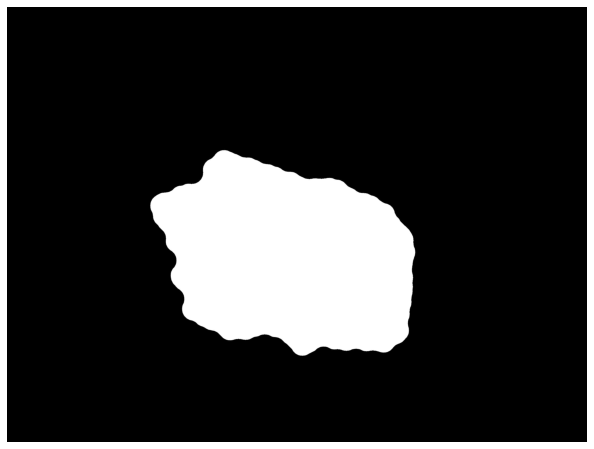

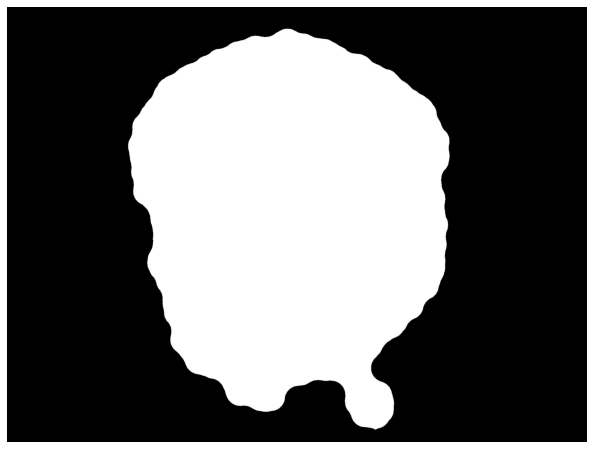

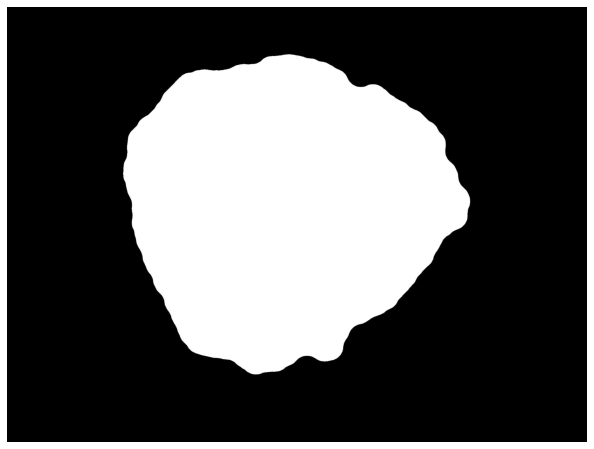

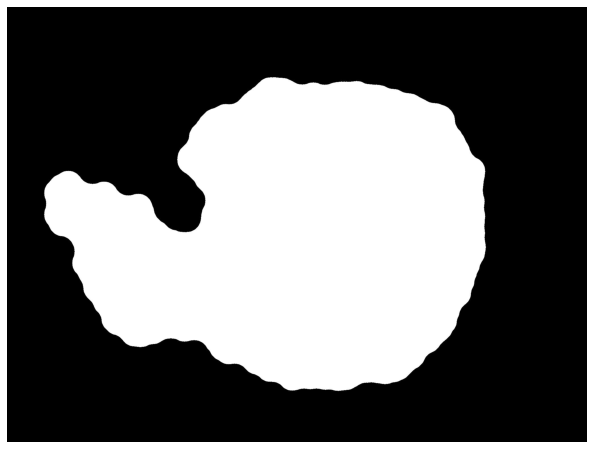

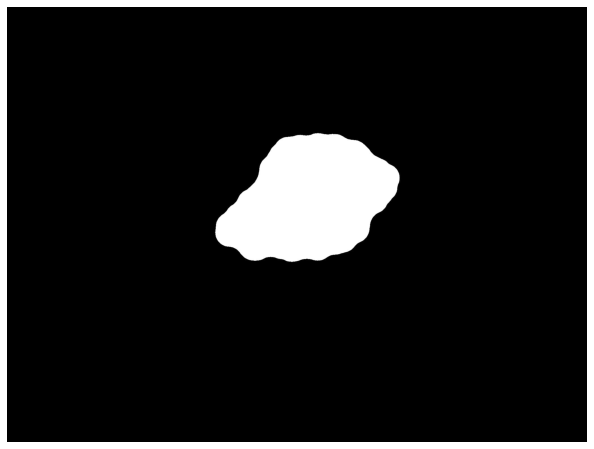

In [6]:
for i in mel_nums:
    path = os.path.join("dataset", 'melanoma', "SEG_"+imgname+i+'.jpg')
    image = Image.open(path)
    plt.figure(figsize=(15,8))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

In [7]:
nev_nums = ['000', '001', '008', '019', '024', '042', '045', '080', '095', '112']
imgname = 'ISIC_0000'

In [8]:
for i in nev_nums:
    print(i)
    path = os.path.join('dataset', 'nevus', imgname+i+'.jpg' )
    path_save = os.path.join("dataset", 'nevus', "SEG_"+imgname+i+'.jpg')
    image = Image.open(path)
    
    ima = PL.RGBtoGRAYnumpy(image) #Convert it into the grayscale image
    out = PL.seg_method(ima)
    
    im = Image.fromarray(out)
    im.save(path_save)
    

000


KeyboardInterrupt: 

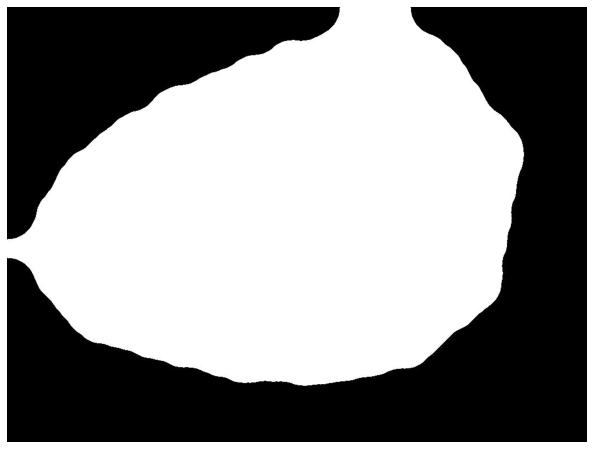

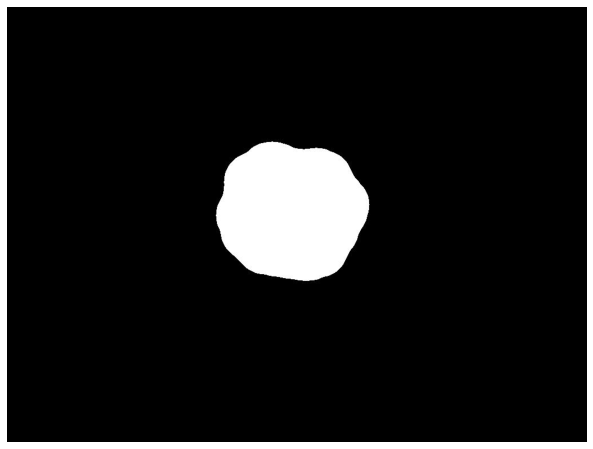

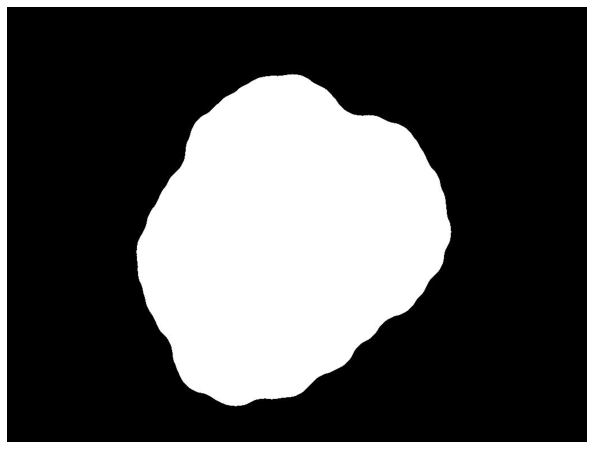

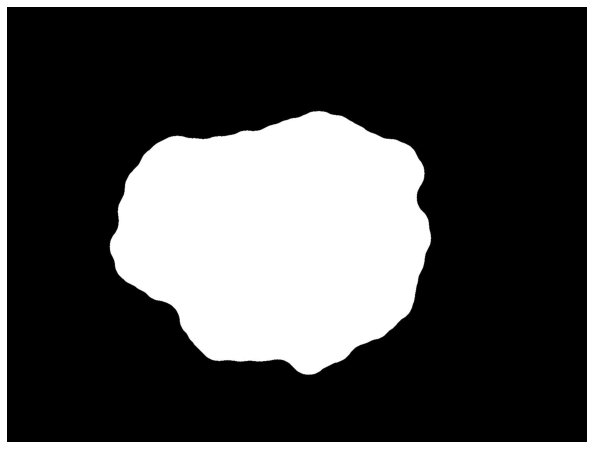

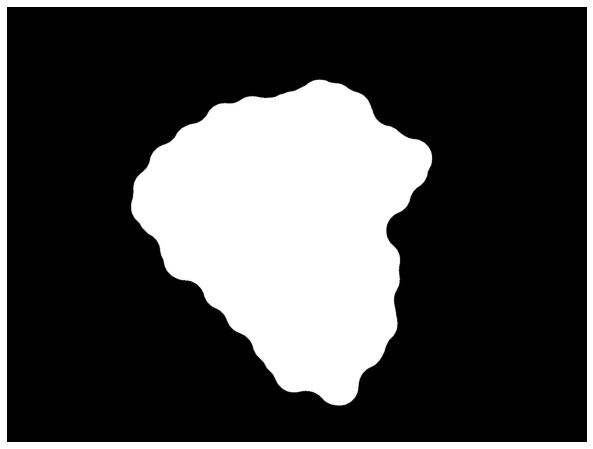

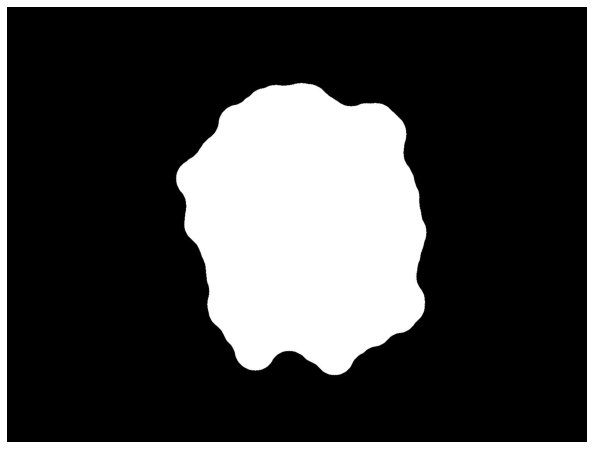

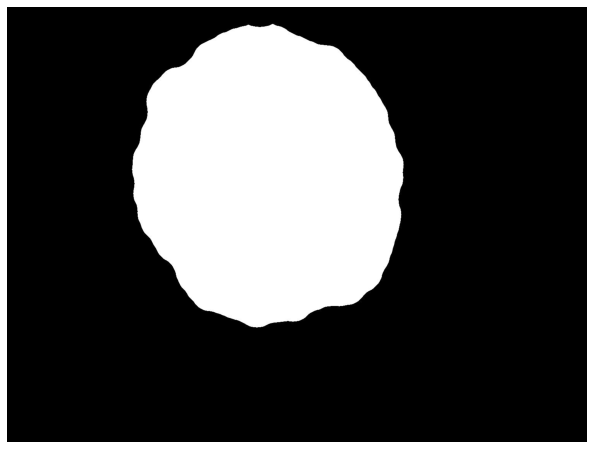

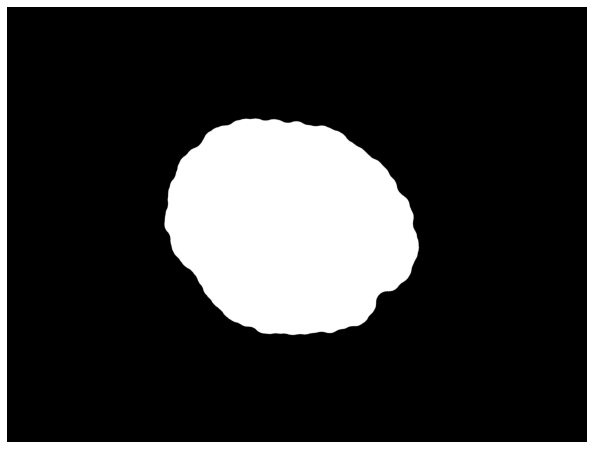

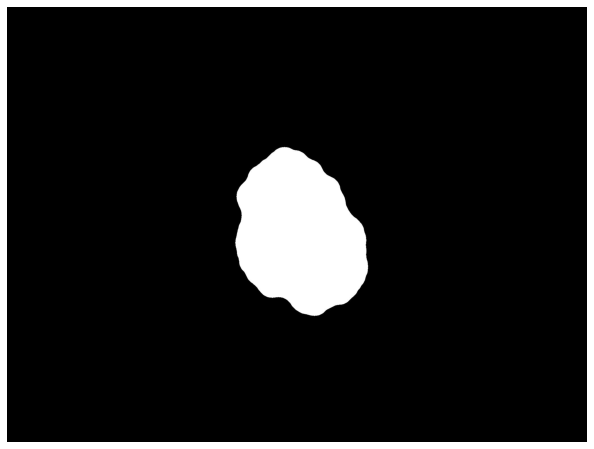

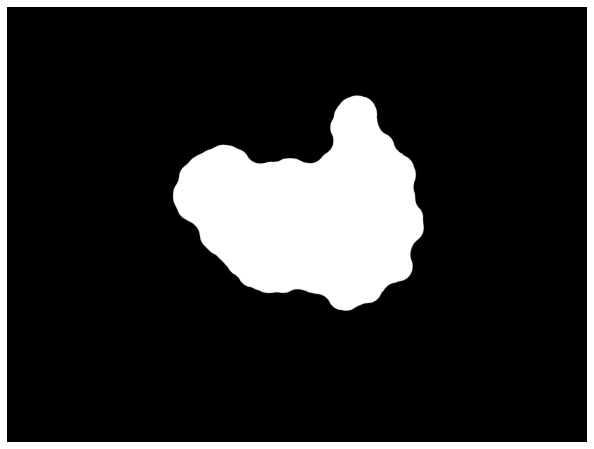

In [9]:
for i in nev_nums:
    path = os.path.join("dataset", 'nevus', "SEG_"+imgname+i+'.jpg')
    image = Image.open(path)
    plt.figure(figsize=(15,8))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()